## Pre Processamento


Para realizar o pré processamento dicidimos recortar os varios videos pelos 4 pioneses que identificam a regiao onde está a ser realmente a serem realizados pontos de setura, diminuindo assim drasticamente o ruido e o tamanho dos videos. 
Tambem decidimos diminuir a qualidade dos videos para o esperado pelas redes neuronais e baixa a quantidade de memoria necessaria.


In [ ]:
import cv2, numpy as np, subprocess, argparse, sys, os
from glob import glob

def detect_crop_rect(frame, min_area, max_area, min_circ):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7,7), 0)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor       = True
    params.blobColor           = 0
    params.filterByArea        = True
    params.minArea             = min_area
    params.maxArea             = max_area
    params.filterByCircularity = True
    params.minCircularity      = min_circ
    det = cv2.SimpleBlobDetector_create(params)
    kps = det.detect(gray)
    if len(kps) != 4:
        raise RuntimeError(f"Expected 4 pins, found {len(kps)}")
    pts = np.array([kp.pt for kp in kps], dtype="float32")
    xs, ys = pts[:,0], pts[:,1]
    x1, x2 = int(xs.min()), int(xs.max())
    y1, y2 = int(ys.min()), int(ys.max())
    return x1, y1, x2-x1, y2-y1

def process_file(src, dst, args):
    # read first frame
    cap = cv2.VideoCapture(src)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"FAIL reading {src}", file=sys.stderr)
        return

    try:
        x,y,w,h = detect_crop_rect(frame,
                                   args.min_area,
                                   args.max_area,
                                   args.min_circ)
    except Exception as e:
        print(f"{os.path.basename(src)}: {e}", file=sys.stderr)
        return

    os.makedirs(os.path.dirname(dst), exist_ok=True)
    vf = f"crop={w}:{h}:{x}:{y},fps=15"
    cmd = [
        "ffmpeg", "-y",
        "-hwaccel", "cuda",               # use CUDA for decode
        "-i", src,
        "-vf", vf,
        "-c:v", "h264_nvenc",             # NVIDIA H.264 encoder
        "-preset", args.preset,           # e.g. p1–p7, fast→slow quality
        "-cq", str(args.cq),              # constant-quality factor (lower→better)
        "-c:a", "copy",
        dst
    ]
    print(f"→ {os.path.basename(src)} → {os.path.basename(dst)}")
    subprocess.run(cmd, check=True)

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--input-dir",  required=True, help="Folder of raw videos")
    p.add_argument("--output-dir", required=True, help="Where to write cropped videos")
    p.add_argument("--min-area",  type=int,   default=100)
    p.add_argument("--max-area",  type=int,   default=2000)
    p.add_argument("--min-circ",  type=float, default=0.7)
    p.add_argument("--preset",    default="p7",
                   help="h264_nvenc preset (p1–p7, higher = better quality/slower)")
    p.add_argument("--cq",        type=int,   default=23,
                   help="h264_nvenc CQ (0–51, lower = better quality/larger)")
    args = p.parse_args()

    exts = ("*.mp4","*.mov","*.mkv","*.avi")
    files = []
    for e in exts:
        files += glob(os.path.join(args.input_dir, e))
    if not files:
        print("No videos found!", file=sys.stderr)
        sys.exit(1)

    for src in sorted(files):
        rel = os.path.relpath(src, args.input_dir)
        dst = os.path.join(args.output_dir, rel)
        process_file(src, dst, args)

if __name__ == "__main__":
    main()

Video Original: 

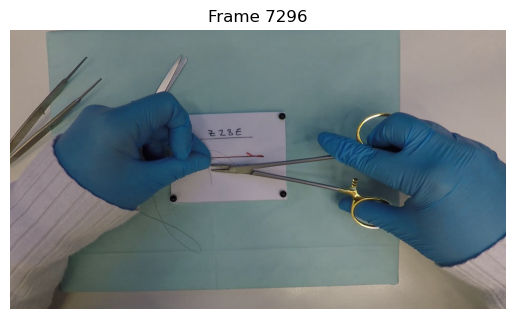

Novo Video: 

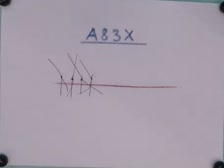


